# copy trianing code from the sharing_code file without normalization data before neural network

  0%|          | 0/15000 [00:00<?, ?it/s]c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 15000/15000 [3:16:52<00:00,  1.27it/s, train Loss=0.00021154076, test loss=0.00024681012]


r2:0.9997079968452454,mse : 0.0002468099119141698, l2_rel : 0.016895392909646034


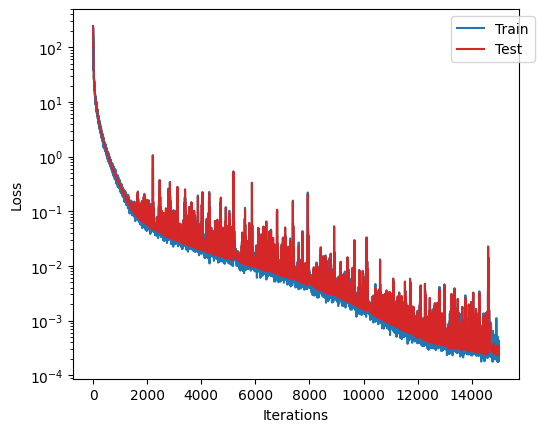

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        # print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, dataset, data_test, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss, 'test loss': loss_test})


    def pred(self, data_test):
        uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            uk_ac = uk.reshape(self.N, self.N, 1)
            uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(uk_solver, (uk_solver.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_solver, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 15000

data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
dataset = DataGenerator(data[:9800], batch_size=20)
data_test = data[9899:]




#    # Initialize and train the model
NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
NN_model.train(dataset, data_test, nIter = epochs)
r2, mse, l2_rel, u_solver, u_pred = NN_model.pred(data_test)
print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

NN_model.plot_losses(f'plots/training_log_iter_{epochs}.png')


import pickle
# saving the parameter
def save_model(model, filename):
    # Save model parameters, architecture and optimizer state
    save_dict = {
        'arch': model.arch,
        'N': model.N,
        'lr': model.lr,
        'eps': model.eps,
        'pp2': model.pp2,
        'qq2': model.qq2,
        'dt': model.dt,
        'L': model.L,
        'h': model.h,
        'x': model.x,
        'y': model.y,
        'params': jax.device_get(model.get_params(model.opt_state)),
        'train_losses': model.train_losses,
        'test_losses': model.test_losses,
        'opt_state': jax.device_get(model.opt_state),  # Save optimizer state too
    }

    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)


save_model(NN_model, f'models/savemodel_{epochs}.pkl')

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
import pickle






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, dataset, data_test, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss, 'test loss': loss_test})


    def pred(self, data_test):
        uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            uk_ac = uk.reshape(self.N, self.N, 1)
            uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(uk_solver, (uk_solver.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_solver, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 5


def load_model(filename):
    # Load the saved model data
    with open(filename, 'rb') as f:
        save_dict = pickle.load(f)

    # Reconstruct the model based on the saved architecture type
    arch = save_dict['arch']
    N = save_dict['N']
    lr = save_dict['lr']
    eps = save_dict['eps']
    pp2 = save_dict['pp2']
    qq2 = save_dict['qq2']
    dt = save_dict['dt']
    L = save_dict['L']
    h = save_dict['h']
    x = save_dict['x']
    y = save_dict['y']

    # Reconstruct architecture layers (FNO, MLP, etc.)
    if arch == 'FNO':
        fno_layers = [
            Dense(64),
            Permute("ijkl->iljk"),
            FNOBlock2D(15),
            Gelu,
            FNOBlock2D(15),
            Gelu,
            FNOBlock2D(15),
            Permute("ijkl->iklj"),
            Dense(128),
            Gelu,
            Dense(1),
        ]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, [], lr, arch)

    elif arch == 'MLP':
        mlp_layers = [16384, 32, 32, 16384]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)

    elif arch == 'modified_MLP':
        mlp_layers = [16384, 32, 32, 16384]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)
    else:
        raise ValueError(f"Unsupported architecture {arch}")

    # Restore model parameters and optimizer state
    model.params = save_dict['params']
    model.opt_state = save_dict['opt_state']
    model.train_losses = save_dict['train_losses']
    model.test_losses = save_dict['test_losses']
    
    return model


data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
# dataset = DataGenerator(data[:9800], batch_size=20)
data_test = data[9800:]




#    # Initialize and train the model
# NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
loaded_model = load_model('models/savemodel_60000.pkl')
# NN_model.train(dataset, data_test, nIter = epochs)
r2, mse, l2_rel, u_solver, u_pred = loaded_model.pred(data_test)
print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')





Denominator shape after expansion: (28, 28, 1)
r2:0.999968945980072,mse : 2.579626743681729e-05, l2_rel : 0.0055268001742661


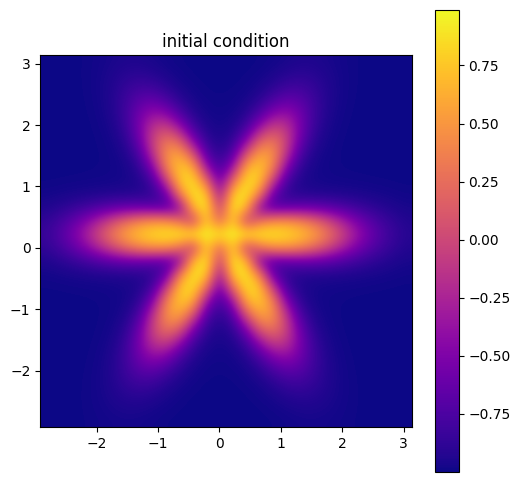

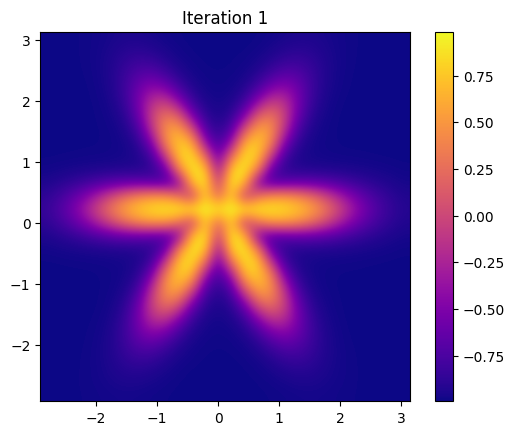

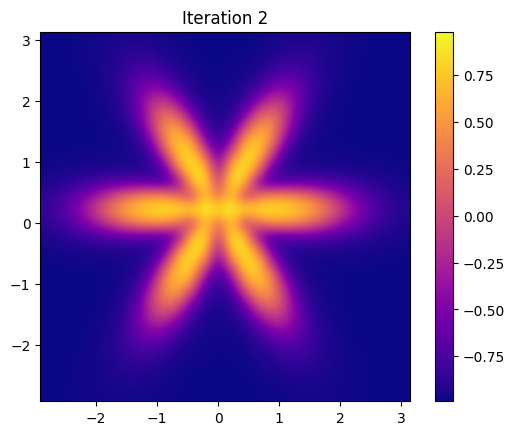

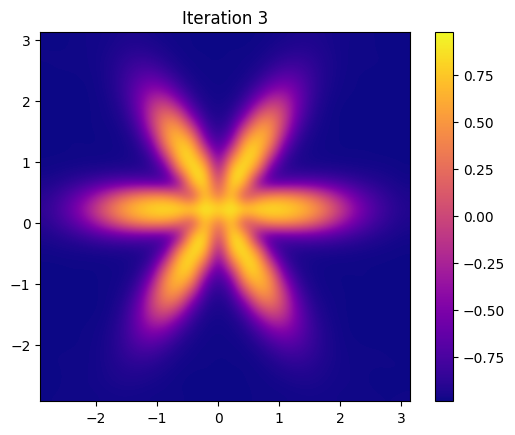

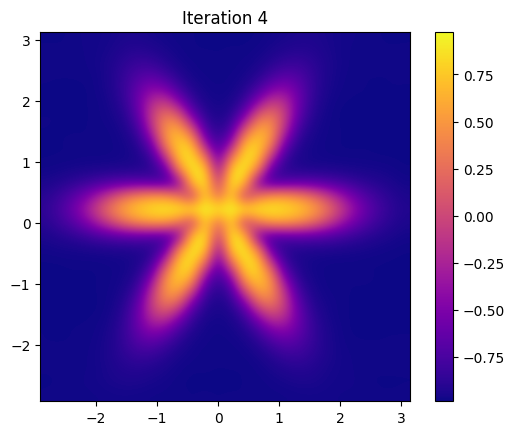

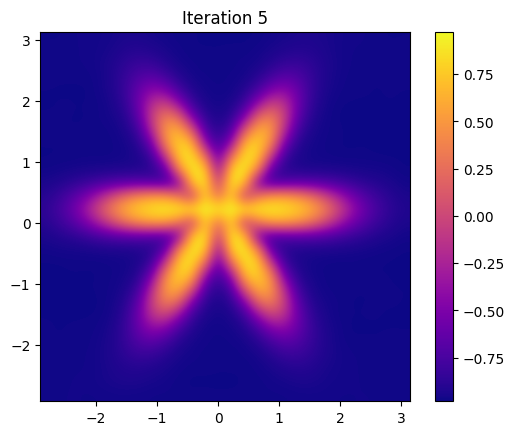

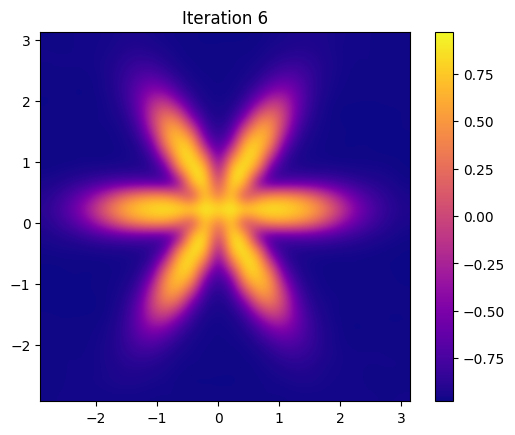

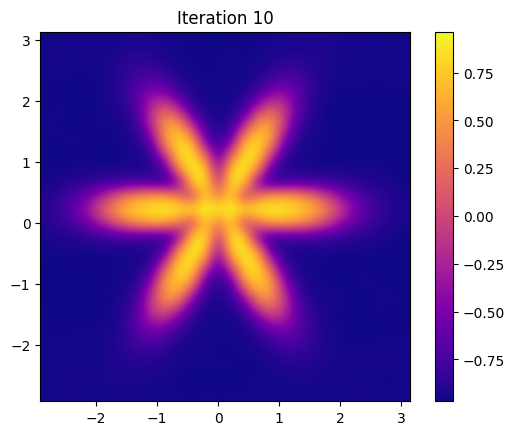

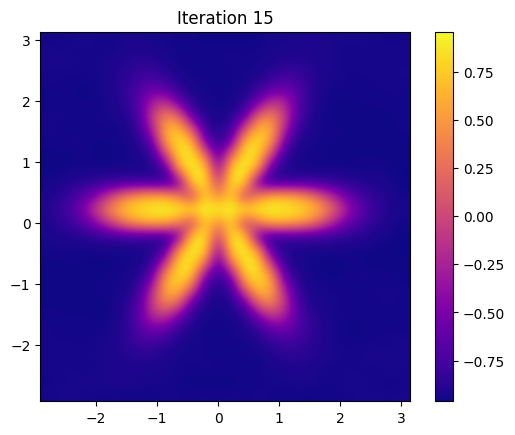

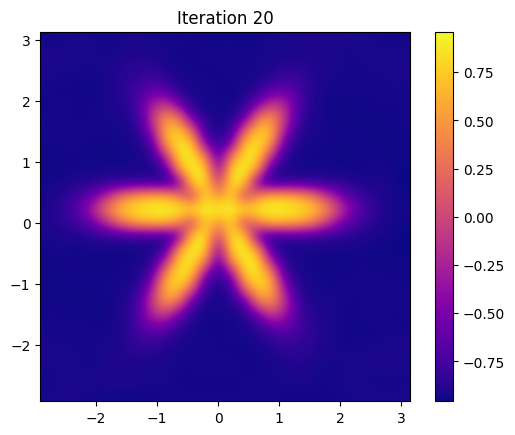

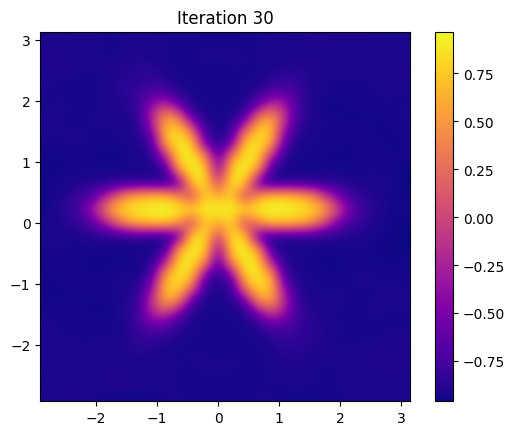

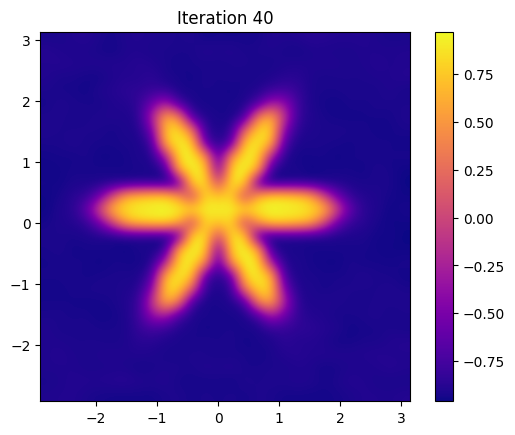

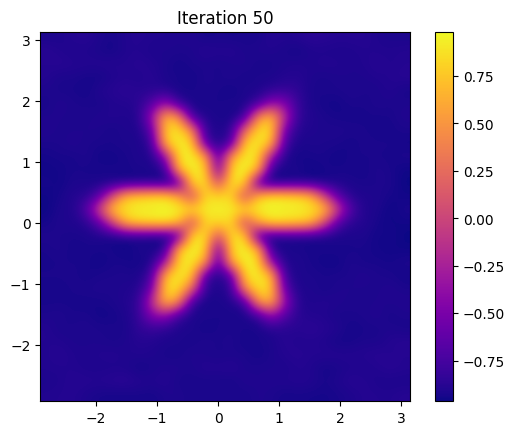

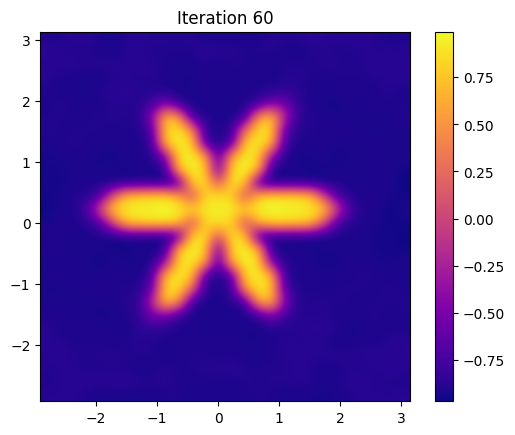

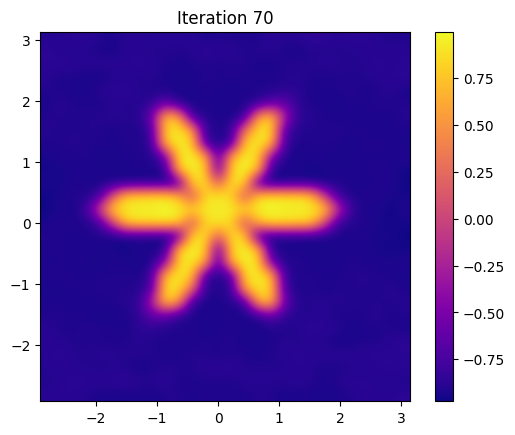

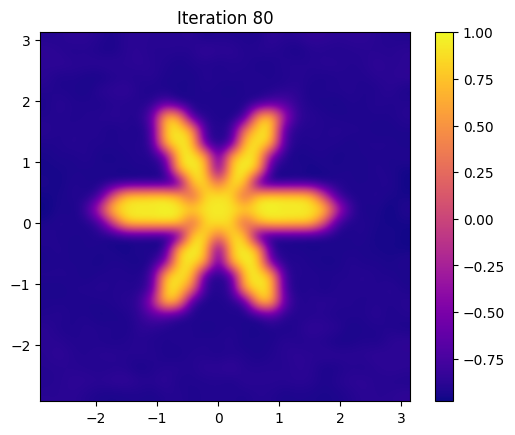

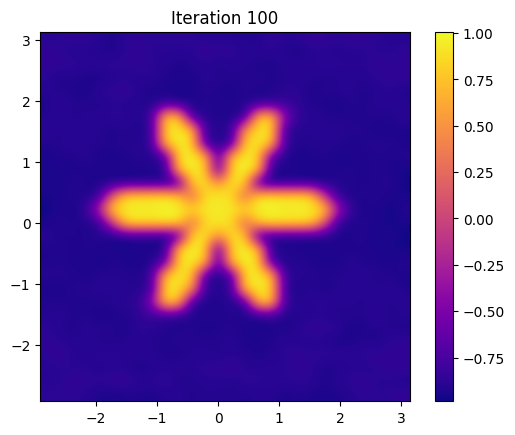

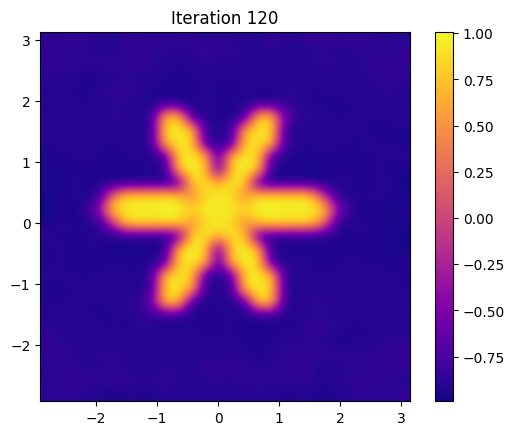

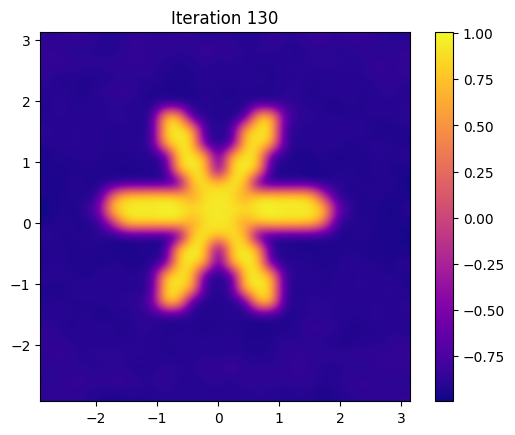

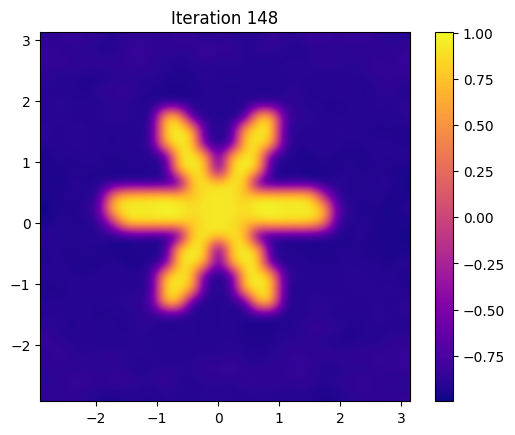

In [3]:

import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter


# @partial(jit, static_argnums=(0,))
def allen_cahn_equation(uk):
    eps = 1.0
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))
    # print("Denominator shape:", denominator.shape)

    # Expand the denominator to match the shape of s_hat (28, 28, 1)
    # denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
    # print("Denominator shape after expansion:", denominator.shape)

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 
    # print("Shape of s_hat (after fft2):", s_hat.shape)

    v_hat = s_hat / denominator  # Now shapes should match
    # print("Shape of v_hat (after division):", v_hat.shape)

    uk = jfft.ifft2(v_hat)  # inverse FFT
    # print("Shape of uk (after ifft2):", uk.shape)

    # uk = uk.reshape(N, N, 1)  # Reshaping to (N, N, 1)
    # print("Shape of uk after reshaping:", uk.shape)

    # Return the real part
    return jnp.real(uk)  # Return only the real part


# def plot_fig()


# difinning the no of grid points in x, y and z
Nx = 28 # number of grid points in x be positive even integer number
Ny = 28 # number of grid points in y be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
#It determines the scale of the transition region (interface width) between phases. its the width of the interface, smaller epsillon refer to the sharp transition

epsillon = 0.5 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
# uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# Define theta and eps
theta = jnp.arctan2(yy, xx)
  # or another appropriate value
uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * epsillon))
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure(figsize = (6, 6))

plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()],cmap='plasma', interpolation='bicubic')
plt.title(f"initial condition")
plt.colorbar()
plt.show()



# # providing the range of iteration



for iter in range(1, Nt):

    
   
    params = loaded_model.get_params(loaded_model.opt_state)
    uk = loaded_model.operator_net(params, uk)
    uk = uk.reshape(N,N)


    if jnp.isnan(uk).any() or jnp.isinf(uk).any():
        print(f"Warning: uk contains NaN or Inf values at iteration {iter}")

    # print(uk.shape)

    if iter == 149:
        break


    if iter in {1, 2, 3, 4, 5, 6,10, 15, 20, 30, 40, 50, 60, 70, 80, 100, 120, 130, 148}:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()
        

        
    
    if iter == 700:
       
        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    
    if iter == 800:
        

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()



    # plt.savefig(f'figs/allen_cahn_pre_{iter}.png', bbox_inches='tight', pad_inches=0)

    # plt.show()
    if iter == 1000:
       

        plt.imshow(jnp.real(uk),extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

        
        # break
    if iter == 1500:
        
        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()


    if iter == 2000:
        

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 3000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 5000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 10000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()

    if iter == 35000:

        plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        plt.title(f"Iteration {iter}")
        plt.colorbar()
        plt.show()
        break


# plt.show()








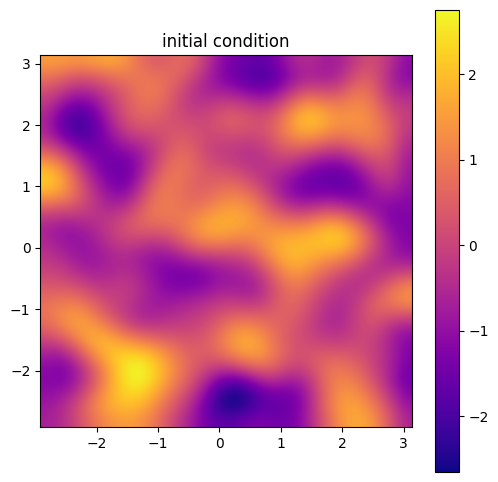

uk shape  (28, 28, 1)


In [9]:

import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

import os 
# @partial(jit, static_argnums=(0,))
def allen_cahn_equation(uk):
    eps = 1.0
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

    v_hat = s_hat / denominator  # Now shapes should match


    uk = jfft.ifft2(v_hat)  # inverse FFT

    # Return the real part
    return jnp.real(uk)  # Return only the real part


# def plot_fig()


# difinning the no of grid points in x, y and z
Nx = 28 # number of grid points in x be positive even integer number
Ny = 28 # number of grid points in y be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

epsillon = 0.5 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# theta = jnp.arctan2(yy, xx)
#   # or another appropriate value
# uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * epsillon))
data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
# dataset = DataGenerator(data[:9800], batch_size=20)
data_test = data[9800:]
uk = data_test[12]


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)

#this figure code is pervious code 
figure1 = plt.figure(figsize = (6, 6))

plt.imshow(jnp.real(uk), extent=[x.min(), x.max(), y.min(), y.max()],cmap='plasma', interpolation='bicubic')
plt.title(f"initial condition")
plt.colorbar()
plt.show()



print('uk shape ', uk.shape)

acinput = uk.reshape(N,N)
modelinput = uk 

# Directory to save images
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Function to save plot
def save_plot(data, model_data, iter_num):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Evolution comparsion (Allen Cahn and Trained model (60k epochs)) among test data", fontsize=16, fontweight='bold')
    im1 = axes[0].imshow(jnp.real(data), cmap='plasma', interpolation='bicubic')
    axes[0].set_title(f"Allen-Cahn Evolution at Iter {iter_num}")
    fig.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(jnp.real(model_data), cmap='plasma', interpolation='bicubic')
    axes[1].set_title(f"Model Evolution at Iter {iter_num}")
    fig.colorbar(im2, ax=axes[1])
    
    plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
    plt.close()
frames = []
for iter in range(1, Nt):
    params = loaded_model.get_params(loaded_model.opt_state)
    modelinput = loaded_model.operator_net(params, modelinput)
    modelinput = modelinput.reshape(Ny, Nx)  # Fixed reshape

    acinput = allen_cahn_equation(acinput)

    # if jnp.isnan(modelinput).any() or jnp.isinf(modelinput).any():
    #     print(f"Warning: modelinput contains NaN or Inf values at iteration {iter}")

    if iter in {1,2,3,4, 5, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100, 120, 130, 148, 500, 1000, 2000, 5000}: # 4, 5, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100, 120, 130, 148, 700, 800, 1000, 1500, 2000, 3000, 5000, 10000, 35000
       
        save_plot(acinput, modelinput, iter)
        frames.append(f"{output_dir}/frame_{iter:04d}.png")
        # fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # im1 = axes[0].imshow(jnp.real(acinput), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        # axes[0].set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes[0])
        
        # im2 = axes[1].imshow(jnp.real(modelinput), extent=[x.min(), x.max(), y.min(), y.max()], cmap='plasma', interpolation='bicubic')
        # axes[1].set_title(f"Model Evolution at Iter {iter}")
        # fig.colorbar(im2, ax=axes[1])
        
        # plt.show()
    
    if iter == 5000:
        break

# # Create GIF
# images = [plt.imread(f) for f in frames]
# fig, ax = plt.subplots()
# im = ax.imshow(images[0])

# def update(frame):
#     im.set_array(images[frame])
#     return [im]

# ani = FuncAnimation(fig, update, frames=len(images), blit=True)
# ani.save("animation/allen_cahn_evolution_model_evoluation_test.gif", writer=PillowWriter(fps=5))

# print("GIF saved as allen_cahn_evolution.gif")



In [10]:
import matplotlib.pyplot as plt
import os
import imageio
from PIL import Image
import numpy as np

# Folder where images are saved
folder = "frames"

# Get the list of image files
image_files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".png")],
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)

# Define a common size for all images (width, height)
common_size = (1200, 600)

# Read in the images and resize them using Resampling.BICUBIC
frames_resized = []
for filename in image_files:
    img = Image.open(os.path.join(folder, filename)).convert("RGB")  # Ensure RGB mode
    img = img.resize(common_size, Image.Resampling.BICUBIC)  # Try BICUBIC for smoother scaling
    frames_resized.append(np.array(img))

# Create a GIF with appropriate duration
gif_path = 'animation/allen_cahn_vs_model_evolution_60k_trained_among_test_data.gif'
os.makedirs("animation", exist_ok=True)
imageio.mimsave(gif_path, frames_resized, duration=460, format='GIF', palettesize=256)

print("GIF created with imageio at a smoother speed.")


GIF created with imageio at a smoother speed.
